# Model for Realistic Larger Data Sets

Based on the real data, we have developed a synthetic model to generate a data set with an arbitrary number of seminars, while keeping the characteristics of a real world data set: number of requests per seminar, how often a seminar is offered, constant number of seminar places, constant ratio of number of students to number of seminars. To scale the data set, the number of seminars is adjusted which is the input parameter of the large data set model.

The input parameter of the algorithm is the number of seminars: `mstar`.

In [18]:
import numpy as np

def generateRequestMatrix(mstar = 10):
    # original parameters of real world data set
    m = 9 # number of seminars
    n = 103 # number of students
    
    nstar = int(n/m*mstar) # number of users
    
    requestsPerSeminar = np.random.randint(low=8, high=30+1, size=mstar) # randint(8,30) 
    
    # generate type of seminar and seminar duplicates
    duplicatesPerSeminar = np.random.choice([1,2,3], p=[0.3,0.6,0.1], replace=True, size=mstar)
    
    uniqueSeminars = (duplicatesPerSeminar.cumsum()>=mstar).argmax()    
    msub = duplicatesPerSeminar[:uniqueSeminars+1].sum()-mstar
    duplicatesPerSeminar = duplicatesPerSeminar[:uniqueSeminars+1]
    duplicatesPerSeminar[-1]-=msub
    
    #assert any(duplicatesPerSeminar>0)
    seminarContent = []
    for seminarType, rep in enumerate(duplicatesPerSeminar):
        seminarContent.append([seminarType]*rep)
    
    seminarContent = np.concatenate(seminarContent)    
    
    # now assign users according toe requests per seminar
    notYetMatchedRequestsPerSeminar = requestsPerSeminar.copy()
 
    xij = np.zeros((nstar, mstar), dtype='bool')    
    seminarIDs = np.arange(mstar)
    absRequestsPerUser = np.array([64, 20, 12, 4, 3])
    probRequestsPerUser = absRequestsPerUser/absRequestsPerUser.sum()
    
    genRequestsPerUser = np.random.choice(np.arange(1,len(absRequestsPerUser)+1), p=probRequestsPerUser, replace=True, size=nstar)
    
    for i in range(nstar):
        if notYetMatchedRequestsPerSeminar.sum()==0:
            break
        semimarsOfUseri = np.random.choice(seminarIDs, p=notYetMatchedRequestsPerSeminar/notYetMatchedRequestsPerSeminar.sum(), replace=False, 
                         size=min(genRequestsPerUser[i], np.sum(notYetMatchedRequestsPerSeminar>0)))
        notYetMatchedRequestsPerSeminar[semimarsOfUseri] -= 1
        xij[i,semimarsOfUseri] = 1
    
    # delete empty seminars 
    xij = np.delete(xij.T, np.where( (xij.sum(axis=0)<=1) )[0], 0).T  
    
    # delete users who did not select any seminar
    xij = np.delete(xij, np.where( (xij.sum(axis=1)==0) )[0], 0)     
    
    return xij, seminarContent



## Request Matrix
Now we randomly generate some data sets and show the characteristics. The request matrix indicates which seminars are requested by which student.

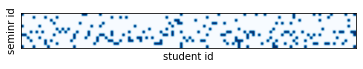

In [14]:
mstar = 12 # number of seminars

xij, contentTypes = generateRequestMatrix(mstar=mstar)
plt.imshow(xij.T, cmap='Blues')    
plt.xlabel('student id')
plt.ylabel('seminr id')
plt.xticks([])
plt.yticks([]);

Now we plot the characteristics of the request matrix: popularity of seminars, number of requested seminar per student.

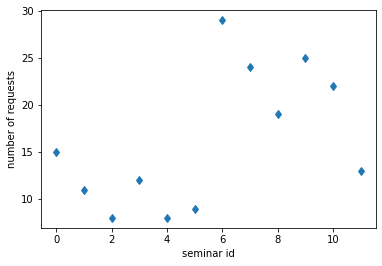

In [28]:
import matplotlib.pyplot as plt 

plt.plot(xij.sum(axis=0), 'd')
plt.xlabel('seminar id')
plt.ylabel('number of requests');

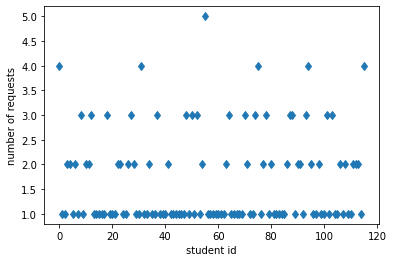

In [29]:
plt.plot(xij.sum(axis=1), 'd')
plt.xlabel('student id')
plt.ylabel('number of requests');

## Seminar Graph
The request matrix can be visualized as a a graph. The nodes of the graph represent the seminars. The size of the node shows how many students are requesting that seminar. An edge is drawn if a student is interested in both seminars connected via the edge. The edge width indicates how many students are interested in both seminars. 

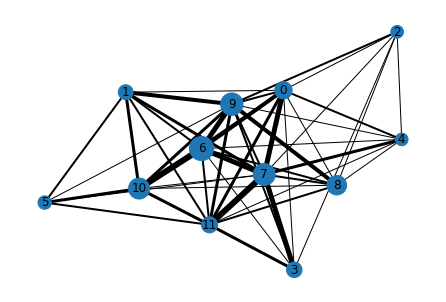

In [30]:
import networkx as nx
import itertools

# generate adjacency matrix out of the request matrix xij
A = np.zeros((xij.shape[1],xij.shape[1]))

for i in range(xij.shape[0]): # iterate over users
    seminars_i = np.where(xij[i,:])[0]
    for (s1,s2) in list(itertools.permutations(seminars_i,2)):
        A[s1,s2] += 1


# draw the graph
G = nx.from_numpy_matrix(A)
edges = G.edges()
weights = [G[u][v]['weight'] for u,v in edges]
nx.draw(G, node_size=xij.sum(axis=0)*20, width=weights, with_labels=True)
plt.show() 

## Simulate Larger Data Sets
Now we generate larger data sets and compare their characteristics.

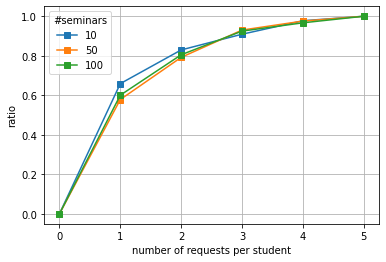

In [31]:
for mstar in [10,50,100]:
    xij, contentTypes = generateRequestMatrix(mstar=mstar)
    req = np.bincount(xij.sum(axis=1))
    plt.plot(req.cumsum()/req.sum(), 's-', label=mstar)
plt.xlabel('number of requests per student')    
plt.ylabel('ratio')
plt.legend(title='#seminars')
plt.grid(which='major');

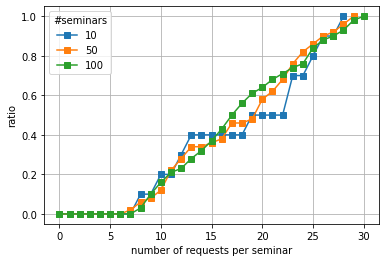

In [33]:
for mstar in [10,50,100]:
    xij, contentTypes = generateRequestMatrix(mstar=mstar)
    req = np.bincount(xij.sum(axis=0))
    plt.plot(req.cumsum()/req.sum(), 's-', label=mstar)
plt.xlabel('number of requests per seminar')    
plt.ylabel('ratio')
plt.legend(title='#seminars')
plt.grid(which='major')    ;